In [1]:
from pathlib import Path
import copy

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder

# GPUのセットアップ
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
# データセットの読み込み
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

dataset = ImageFolder("raw_dataset", data_transforms['train'])
dataset.class_to_idx

{'with_mask': 0, 'without_mask': 1}

In [3]:
# 訓練用、評価用にデータを分ける
all_size = len(dataset)
train_size = int(0.8 * all_size)
val_size = all_size - train_size
dataset_size  = {"train":train_size, "val":val_size}
train_data, val_data = random_split(dataset, [train_size, val_size])

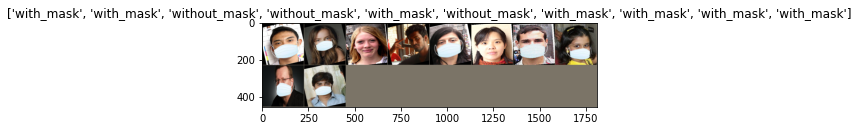

In [4]:
# DataLoaderを定義
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
val_loader = DataLoader(val_data, batch_size=10, shuffle=False)
dataloaders = {'train':train_loader, 'val':val_loader}

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()
class_names = list(dataset.class_to_idx.keys())

# Make a grid from batch
out = torchvision.utils.make_grid(images)

imshow(out, title=[class_names[x] for x in labels])

In [5]:
# モデルの定義
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53* 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), 16*53*53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [8]:
EPOCH = 100

best_model_wts = copy.deepcopy(net.state_dict())
best_acc = 0.0

#途中経過保存用に、リストを持った辞書を作ります。
loss_dict ={"train" : [],  "val" : []}
acc_dict = {"train" : [],  "val" : []}

for epoch in range(EPOCH):  # loop over the dataset multiple times
    if (epoch+1)%5 == 0:#５回に１回エポックを表示します。
        print('Epoch {}/{}'.format(epoch, EPOCH - 1))
        print('-' * 10)
    for phase in ['train', 'val']:
        if phase == 'train':
            net.train()
        else:
            net.eval()

        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
                
            with torch.set_grad_enabled(phase == 'train'):
                outputs = net(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                optimizer.zero_grad()

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / dataset_size[phase]
        epoch_acc = running_corrects.double() / dataset_size[phase]
        loss_dict[phase].append(epoch_loss)
        acc_dict[phase].append(epoch_acc)
        
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(net.state_dict())

net.load_state_dict(best_model_wts)
print('Best val acc: {:.4f}'.format(best_acc))
print('Finished Training')

train Loss: 0.0359 Acc: 0.9891
val Loss: 0.0584 Acc: 0.9783
train Loss: 0.0573 Acc: 0.9809
val Loss: 0.0535 Acc: 0.9819
train Loss: 0.0367 Acc: 0.9882
val Loss: 0.0621 Acc: 0.9855
train Loss: 0.0323 Acc: 0.9909
val Loss: 0.0598 Acc: 0.9783
Epoch 4/9
----------
train Loss: 0.0193 Acc: 0.9927
val Loss: 0.0428 Acc: 0.9855
train Loss: 0.0189 Acc: 0.9909
val Loss: 0.0685 Acc: 0.9891
train Loss: 0.0270 Acc: 0.9891
val Loss: 0.0377 Acc: 0.9819
train Loss: 0.0170 Acc: 0.9945
val Loss: 0.0617 Acc: 0.9783
train Loss: 0.0190 Acc: 0.9936
val Loss: 0.0639 Acc: 0.9819
Epoch 9/9
----------
train Loss: 0.0095 Acc: 0.9982
val Loss: 0.0581 Acc: 0.9819
Best val acc: 0.9891
Finished Training


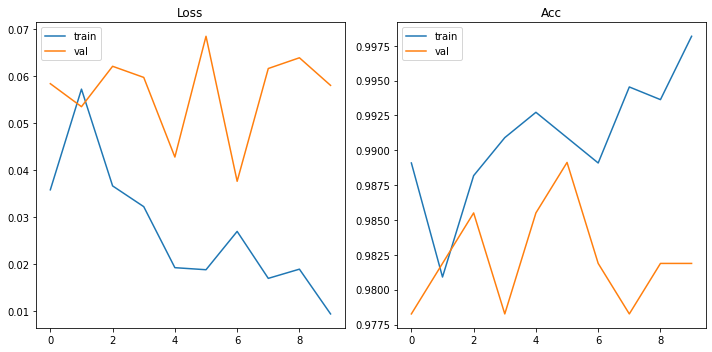

In [9]:
loss_train = loss_dict["train"]
loss_val   = loss_dict["val"]

acc_train = acc_dict["train"]
acc_val   = acc_dict["val"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

#０個目のグラフ
axes[0].plot(range(EPOCH), loss_train, label = "train")
axes[0].plot(range(EPOCH), loss_val,    label =  "val")
axes[0].set_title("Loss")
axes[0].legend()#各グラフのlabelを表示

#１個目のグラフ
axes[1].plot(range(EPOCH), acc_train, label = "train")
axes[1].plot(range(EPOCH), acc_val,    label =  "val")
axes[1].set_title("Acc")
axes[1].legend()

#０個目と１個目のグラフが重ならないように調整
fig.tight_layout()

In [10]:
# モデルの保存(pth)
torch.save(net.state_dict(),"detector/face_mask_detector.pth")

# モデルの保存(ONNX)
trained_model = Net()
trained_model.load_state_dict(torch.load('detector/face_mask_detector.pth', map_location=torch.device('cpu')))
dummy_input = torch.randn(1, 3, 224, 224) 
torch.onnx.export(trained_model, dummy_input, "detector/face_mask_detector.onnx") 

__main__.Net